In [1]:
# 1) Install dependencies (run once)
!pip install -q sentence-transformers transformers umap-learn scikit-learn matplotlib pandas seaborn asttokens

# 2) Imports
import os, io, tokenize, ast
from pathlib import Path
import pandas as pd

# 3) Create snippets folder and write example snippets (replace/extend these with your own later)
os.makedirs('snippets', exist_ok=True)

examples = {
"snippet01_add.py": """def add(a, b):\n    return a + b\n""",
"snippet02_counter_class.py": """class Counter:\n    def __init__(self):\n        self.c = 0\n    def inc(self):\n        self.c += 1\n    def value(self):\n        return self.c\n""",
"snippet03_factorial_recursive.py": """def factorial(n):\n    if n <= 1:\n        return 1\n    return n * factorial(n-1)\n""",
"snippet04_file_io.py": """import json\n\ndef save_json(path, data):\n    with open(path,'w') as f:\n        json.dump(data, f)\n""",
"snippet05_list_comp.py": """def squares(n):\n    return [i*i for i in range(n)]\n""",
"snippet06_decorator.py": """def log(fn):\n    def wrapper(*a, **k):\n        print('calling', fn.__name__)\n        return fn(*a, **k)\n    return wrapper\n\n@log\ndef greet(name):\n    return f'Hello {name}'\n""",
"snippet07_async_gen.py": """import asyncio\n\nasync def fetch(x):\n    await asyncio.sleep(0.01)\n    return x*2\n""",
"snippet08_nested_functions.py": """def outer(x):\n    def inner(y):\n        return x + y\n    return inner\n""",
"snippet09_comprehension_map_filter.py": """def process(nums):\n    return list(map(lambda x: x*2, filter(lambda x: x%2==0, nums)))\n""",
"snippet10_try_except.py": """def safe_div(a, b):\n    try:\n        return a / b\n    except ZeroDivisionError:\n        return None\n"""
}

for fname, code in examples.items():
    with open(os.path.join('snippets', fname), 'w') as f:
        f.write(code)

# 4) Load and preview snippets
snippet_files = sorted(Path('snippets').glob('*.py'))
snippets = []
for p in snippet_files:
    text = p.read_text()
    first_line = text.splitlines()[0] if text.splitlines() else ""
    snippets.append({'filename': p.name, 'lines': len(text.splitlines()), 'first_line': first_line})

df = pd.DataFrame(snippets)
print("Snippets found:", len(df))
display(df)


Snippets found: 10


,filename,lines,first_line
0,snippet01_add.py,2,"def add(a, b):"
1,snippet02_counter_class.py,7,class Counter:
2,snippet03_factorial_recursive.py,4,def factorial(n):
3,snippet04_file_io.py,5,import json
4,snippet05_list_comp.py,2,def squares(n):
5,snippet06_decorator.py,9,def log(fn):
6,snippet07_async_gen.py,5,import asyncio
7,snippet08_nested_functions.py,4,def outer(x):
8,snippet09_comprehension_map_filter.py,2,def process(nums):
9,snippet10_try_except.py,5,"def safe_div(a, b):"


In [2]:
import ast

def parse_code_features(code):
    tree = ast.parse(code)
    features = {
        "n_functions": 0,
        "n_classes": 0,
        "imports": [],
        "function_names": [],
        "class_names": [],
        "has_recursion": False,
        "has_list_comp": False,
        "lines": len(code.splitlines())
    }

    for node in ast.walk(tree):
        if isinstance(node, ast.FunctionDef):
            features["n_functions"] += 1
            features["function_names"].append(node.name)

            # Detect recursion (function calls itself)
            for child in ast.walk(node):
                if isinstance(child, ast.Call) and isinstance(child.func, ast.Name):
                    if child.func.id == node.name:
                        features["has_recursion"] = True

        elif isinstance(node, ast.ClassDef):
            features["n_classes"] += 1
            features["class_names"].append(node.name)

        elif isinstance(node, ast.Import):
            for n in node.names:
                features["imports"].append(n.name)

        elif isinstance(node, ast.ImportFrom):
            base = (node.module or "")
            for n in node.names:
                features["imports"].append(base + "." + n.name if base else n.name)

        elif isinstance(node, ast.ListComp):
            features["has_list_comp"] = True

    return features


# --- Parse all snippets and display summary ---
results = []
for s in snippets:
    code = Path('snippets') / s['filename']
    s['features'] = parse_code_features(code.read_text())
    row = {"file": s['filename'], **s['features']}
    results.append(row)

df_features = pd.DataFrame(results)
display(df_features)


,file,n_functions,n_classes,imports,function_names,class_names,has_recursion,has_list_comp,lines
0,snippet01_add.py,1,0,[],[add],[],False,False,2
1,snippet02_counter_class.py,3,1,[],"[__init__, inc, value]",[Counter],False,False,7
2,snippet03_factorial_recursive.py,1,0,[],[factorial],[],True,False,4
3,snippet04_file_io.py,1,0,[json],[save_json],[],False,False,5
4,snippet05_list_comp.py,1,0,[],[squares],[],False,True,2
5,snippet06_decorator.py,3,0,[],"[log, greet, wrapper]",[],False,False,9
6,snippet07_async_gen.py,0,0,[asyncio],[],[],False,False,5
7,snippet08_nested_functions.py,2,0,[],"[outer, inner]",[],False,False,4
8,snippet09_comprehension_map_filter.py,1,0,[],[process],[],False,False,2
9,snippet10_try_except.py,1,0,[],[safe_div],[],False,False,5


In [5]:
from transformers import AutoTokenizer

# ---------- A) Lexical Tokenization (same as before) ----------
def python_lex_tokens(code):
    tokens = []
    try:
        g = tokenize.generate_tokens(io.StringIO(code).readline)
        for toknum, tokval, start, end, line in g:
            tokens.append((tokenize.tok_name[toknum], tokval))
    except Exception as e:
        tokens = []
    return tokens

# Reload all snippets
snippet_files = sorted(Path('snippets').glob('*.py'))
snippets = [{"filename": p.name, "code": p.read_text()} for p in snippet_files]

print("Example lexical tokens from first snippet:\n")
print(python_lex_tokens(snippets[0]["code"])[:15])

# ---------- ✅ FIXED MODEL NAMES ----------
model_names = {
    "MiniLM": "sentence-transformers/all-MiniLM-L6-v2",
    "DistilRoBERTa": "sentence-transformers/stsb-distilroberta-base-v2",
    "MPNet": "sentence-transformers/all-mpnet-base-v2"
}

# ---------- Load Tokenizers ----------
model_tokenizers = {}
for k, model_name in model_names.items():
    print(f"Loading tokenizer for {k} ({model_name})...")
    model_tokenizers[k] = AutoTokenizer.from_pretrained(model_name)

# ---------- Token Count Comparison ----------
rows = []
for s in snippets:
    code = s["code"]
    lex_tokens = python_lex_tokens(code)
    row = {"file": s["filename"], "lex_tokens": len(lex_tokens)}
    for k, tok in model_tokenizers.items():
        tokens = tok.tokenize(code)
        row[f"{k}_tokens"] = len(tokens)
    rows.append(row)

df_tokens = pd.DataFrame(rows)
display(df_tokens)


Example lexical tokens from first snippet:

[('NAME', 'def'), ('NAME', 'add'), ('OP', '('), ('NAME', 'a'), ('OP', ','), ('NAME', 'b'), ('OP', ')'), ('OP', ':'), ('NEWLINE', '\n'), ('INDENT', '    '), ('NAME', 'return'), ('NAME', 'a'), ('OP', '+'), ('NAME', 'b'), ('NEWLINE', '\n')]
Loading tokenizer for MiniLM (sentence-transformers/all-MiniLM-L6-v2)...


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Loading tokenizer for DistilRoBERTa (sentence-transformers/stsb-distilroberta-base-v2)...


tokenizer_config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/680 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Loading tokenizer for MPNet (sentence-transformers/all-mpnet-base-v2)...


tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

,file,lex_tokens,MiniLM_tokens,DistilRoBERTa_tokens,MPNet_tokens
0,snippet01_add.py,17,12,16,12
1,snippet02_counter_class.py,51,41,71,41
2,snippet03_factorial_recursive.py,31,25,40,25
3,snippet04_file_io.py,38,35,44,35
4,snippet05_list_comp.py,24,19,22,19
5,snippet06_decorator.py,66,64,80,64
6,snippet07_async_gen.py,28,28,35,28
7,snippet08_nested_functions.py,27,18,33,18
8,snippet09_comprehension_map_filter.py,38,36,37,36
9,snippet10_try_except.py,31,26,48,26


In [6]:
from sentence_transformers import SentenceTransformer
import numpy as np
import os

# Folder to store embeddings
os.makedirs('artifacts', exist_ok=True)

# ---------- A) Load pretrained models ----------
model_names = {
    "MiniLM": "all-MiniLM-L6-v2",
    "DistilRoBERTa": "stsb-distilroberta-base-v2",
    "MPNet": "all-mpnet-base-v2"
}

models = {}
for k, model_id in model_names.items():
    print(f"Loading {k} model...")
    models[k] = SentenceTransformer(model_id)

# ---------- B) Encode all snippets ----------
codes = [s['code'] for s in snippets]
embeddings = {}

for k, model in models.items():
    print(f"\nEncoding with {k} ...")
    emb = model.encode(codes, convert_to_numpy=True, show_progress_bar=True)
    embeddings[k] = emb
    print(f"{k} embeddings shape:", emb.shape)

# ---------- C) Save embeddings for reproducibility ----------
for k, emb in embeddings.items():
    np.save(f"artifacts/embeddings_{k}.npy", emb)
    print(f"Saved: artifacts/embeddings_{k}.npy")


Loading MiniLM model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Loading DistilRoBERTa model...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Loading MPNet model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Encoding with MiniLM ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

MiniLM embeddings shape: (10, 384)

Encoding with DistilRoBERTa ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

DistilRoBERTa embeddings shape: (10, 768)

Encoding with MPNet ...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

MPNet embeddings shape: (10, 768)
Saved: artifacts/embeddings_MiniLM.npy
Saved: artifacts/embeddings_DistilRoBERTa.npy
Saved: artifacts/embeddings_MPNet.npy


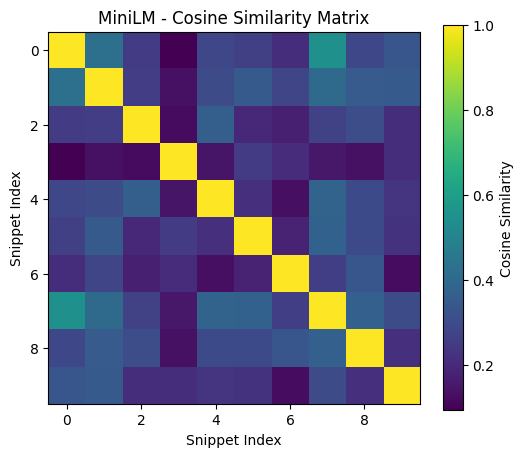

,Model A,Model B,Spearman Correlation
0,MiniLM,DistilRoBERTa,0.6025
1,MiniLM,MPNet,0.7876
2,DistilRoBERTa,MPNet,0.4619


In [7]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ---------- A) Compute cosine similarity matrices ----------
def similarity_matrix(emb):
    return cosine_similarity(emb)

sim_mats = {k: similarity_matrix(v) for k, v in embeddings.items()}

# ---------- B) Visualize a sample matrix ----------
plt.figure(figsize=(6, 5))
plt.imshow(sim_mats['MiniLM'], cmap='viridis', interpolation='nearest')
plt.title('MiniLM - Cosine Similarity Matrix')
plt.colorbar(label='Cosine Similarity')
plt.xlabel('Snippet Index')
plt.ylabel('Snippet Index')
plt.show()

# ---------- C) Compare models using Spearman correlation ----------
pairs = []
names = list(sim_mats.keys())

for i in range(len(names)):
    for j in range(i + 1, len(names)):
        a = sim_mats[names[i]]
        b = sim_mats[names[j]]
        # take only upper-triangle values (to avoid duplicates)
        iu = np.triu_indices_from(a, k=1)
        ra, rb = a[iu], b[iu]
        corr, _ = spearmanr(ra, rb)
        pairs.append({
            "Model A": names[i],
            "Model B": names[j],
            "Spearman Correlation": round(corr, 4)
        })

df_corr = pd.DataFrame(pairs)
display(df_corr)


📊 Visualizing MiniLM embeddings...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


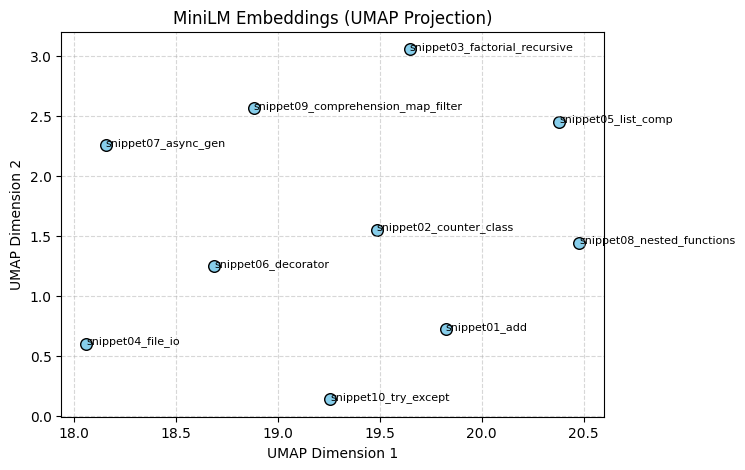

📊 Visualizing DistilRoBERTa embeddings...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


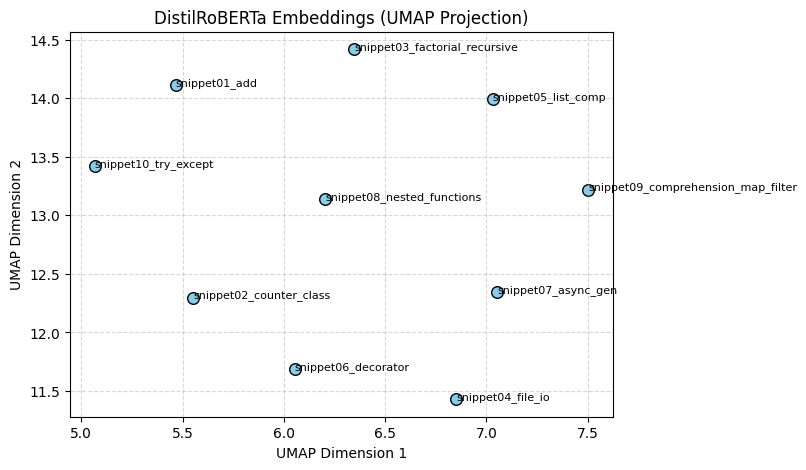

📊 Visualizing MPNet embeddings...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


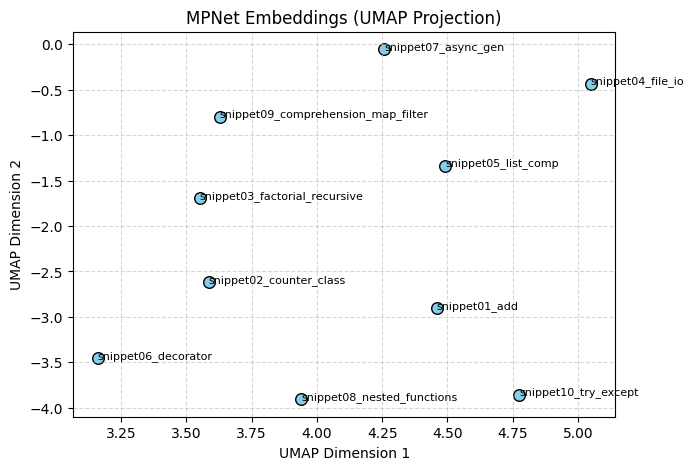

In [8]:
import umap
import matplotlib.pyplot as plt
import numpy as np

# ---------- A) Define 2D projection function ----------
def plot_2d_embeddings(emb, title, labels=None):
    reducer = umap.UMAP(random_state=42, n_neighbors=5, min_dist=0.3)
    emb_2d = reducer.fit_transform(emb)

    plt.figure(figsize=(7, 5))
    scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c='skyblue', s=70, edgecolors='black')

    for i, txt in enumerate([s['filename'] for s in snippets]):
        plt.annotate(txt.replace(".py",""), (emb_2d[i, 0], emb_2d[i, 1]), fontsize=8)

    plt.title(title)
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


# ---------- B) Plot embeddings for each model ----------
for k, emb in embeddings.items():
    print(f"📊 Visualizing {k} embeddings...")
    plot_2d_embeddings(emb, f"{k} Embeddings (UMAP Projection)")


In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import pandas as pd

# ---------- A) Choose number of clusters ----------
# You can choose based on intuition; here we use 4 for diversity
num_clusters = 4

cluster_labels = {}
for name, emb in embeddings.items():
    km = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    cluster_labels[name] = km.fit_predict(emb)
    print(f"{name}: cluster labels -> {cluster_labels[name]}")

# ---------- B) Compare models with Adjusted Rand Index ----------
names = list(cluster_labels.keys())
ari_results = []

for i in range(len(names)):
    for j in range(i + 1, len(names)):
        ari = adjusted_rand_score(cluster_labels[names[i]], cluster_labels[names[j]])
        ari_results.append({
            "Model A": names[i],
            "Model B": names[j],
            "Adjusted Rand Index": round(ari, 4)
        })

df_ari = pd.DataFrame(ari_results)
display(df_ari)


MiniLM: cluster labels -> [1 1 3 2 3 1 0 1 0 1]
DistilRoBERTa: cluster labels -> [2 3 1 0 1 3 0 1 1 2]
MPNet: cluster labels -> [1 1 1 2 0 1 0 1 0 3]


,Model A,Model B,Adjusted Rand Index
0,MiniLM,DistilRoBERTa,0.0741
1,MiniLM,MPNet,0.3911
2,DistilRoBERTa,MPNet,0.0476


📊 Combined Model Comparison Summary:


,Model A,Model B,Spearman Correlation,Adjusted Rand Index
0,DistilRoBERTa,MPNet,0.4619,0.0476
1,MiniLM,DistilRoBERTa,0.6025,0.0741
2,MiniLM,MPNet,0.7876,0.3911


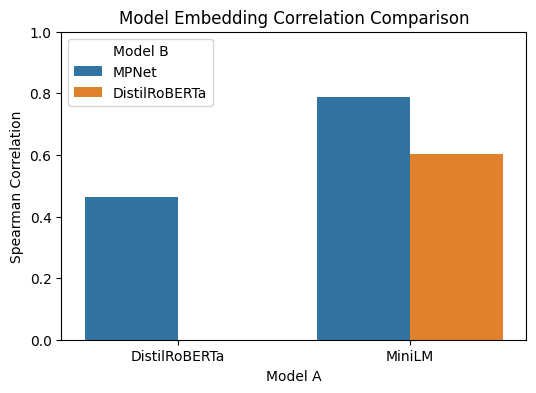

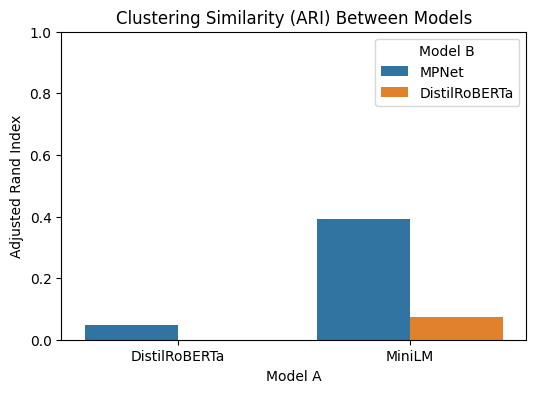

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ---------- A) Combine correlation and ARI results ----------
summary_df = df_corr.merge(df_ari, on=["Model A", "Model B"], how="outer")

# ---------- B) Display combined results ----------
print("📊 Combined Model Comparison Summary:")
display(summary_df)

# ---------- C) Plot correlations ----------
plt.figure(figsize=(6,4))
sns.barplot(x="Model A", y="Spearman Correlation", hue="Model B", data=summary_df)
plt.title("Model Embedding Correlation Comparison")
plt.ylim(0,1)
plt.legend(title="Model B")
plt.show()

# ---------- D) Plot Adjusted Rand Index ----------
plt.figure(figsize=(6,4))
sns.barplot(x="Model A", y="Adjusted Rand Index", hue="Model B", data=summary_df)
plt.title("Clustering Similarity (ARI) Between Models")
plt.ylim(0,1)
plt.legend(title="Model B")
plt.show()
